# Resource Estimation of QAOA

This notebook has all the graphs that we produced using the Resource Estimator

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Qsharp
import qsharp
from qsharp_widgets import EstimatesOverview

In [2]:
%%qsharp
// This is the Q# snippet used to create and simulate the QAOA circuit. 
namespace qaoa_note{

    open Microsoft.Quantum.Measurement;

    // Function for getting flat index
    operation flat_index(n: Int, i: Int, j: Int): Int{
        return n*i + j
    }
    // Cost Hamiltonian
    operation cost_unitary(qubits: Qubit[], gamma: Double, quadratics: Double[], linears: Double[]): Unit{
        
        let n_qubits = Length(linears);
        mutable quad_sum : Double = 0.0;

        // RZ Gates
        for qubit in 0..n_qubits-1{
            set quad_sum = 0.0;
            for quad_qubit in 0..n_qubits-1{
                set quad_sum += quadratics[flat_index(n_qubits,qubit,quad_qubit)];
            }
            Rz(0.5 * (linears[qubit] + quad_sum) * gamma, qubits[qubit])
        }
        // RZZ Gates
        for i in 0..n_qubits-1{
            for j in i+1..n_qubits-1{                
                Rzz(0.25 * quadratics[flat_index(n_qubits,i,j)] * gamma, qubits[i], qubits[j])
            }
        }
    }

    // Mixer Hamiltonian
    operation mixer_unitary(qubits: Qubit[], beta: Double) : Unit{
        for qubit in qubits{
            Rx(2.0 * beta,qubit);
        }
    }

    // Function to create the QAOA circuit.
    operation circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[], linears: Double[]) : Int {

        use q = Qubit[NQubits]; 
        mutable integer_result = 0;
        
        // State Preparation |+>
        ApplyToEachA(H,q);

        for layer in 0..Layers-1{
            cost_unitary(q, gammas[layer], quadratics, linears);
            mixer_unitary(q, betas[layer]);
        }
        // Return the bitstring as an integer.
        return MeasureInteger(q);
    }
}

In [3]:
# Defining helper functions
def arr_to_str(a):
    """
    Converts a given array to a string representation.

    Args:
        a (list): The array to be converted.

    Returns:
        str: The string representation of the array.

    Example:
        >>> arr_to_str([1, 2, 3])
        '[1,2,3]'
    """
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string[:-1] + ']'

def generate_qsharp_string(n_qubits: int = 3,layers: int = 3) -> str:
    """Function to generate dummy input strings from no. of qubits and no. of layers"""
    
    # Preparing inputs for the Q# function.
    quadratics = np.array([1.1] * n_qubits**2)
    linears = np.array([1.2] * n_qubits)

    gammas = np.random.rand(layers)
    betas = np.random.rand(layers)

    input_str = f"{n_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears)}"
    qsharp_string = f"qaoa_note.circuit({input_str})"

    return qsharp_string

In [4]:
input_str = generate_qsharp_string(3,3)

## Using the Resourse Estimator
Below this cell is the testing and changing of parameters

In [5]:
runNames = [
    "Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴",
    "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁴", "F-Majorana ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁶", "F-Majorana ns, 10⁻⁶"]

error_budget = .09
result = qsharp.estimate(input_str,params = [
    {
        "errorBudget": error_budget,
        "qubitParams": { "name": "qubit_gate_ns_e3" },
        "qecScheme": { "name": "surface_code" },
        "estimateType": "frontier", # Pareto frontier estimation
    },
    {
        "errorBudget": error_budget,
        "qubitParams": { "name": "qubit_gate_ns_e4" },
        "qecScheme": { "name": "surface_code" },
        "estimateType": "frontier", # Pareto frontier estimation
    },
    {
        "errorBudget": error_budget,
        "qubitParams": { "name": "qubit_gate_us_e3" },
        "qecScheme": { "name": "surface_code" },
        "estimateType": "frontier", # Pareto frontier estimation
    },
    {
        "errorBudget": error_budget,
        "qubitParams": { "name": "qubit_gate_us_e4" },
        "qecScheme": { "name": "surface_code" },
        "estimateType": "frontier", # Pareto frontier estimation
    },
    {
        "errorBudget": error_budget,
        "qubitParams": { "name": "qubit_maj_ns_e4" },
        "qecScheme": { "name": "surface_code" },
        "estimateType": "frontier", # Pareto frontier estimation
    },
    {
        "errorBudget": error_budget,
        "qubitParams": { "name": "qubit_maj_ns_e4" },
        "qecScheme": { "name": "floquet_code" },
        "estimateType": "frontier", # Pareto frontier estimation
    },
    {
        "errorBudget": error_budget,
        "qubitParams": { "name": "qubit_maj_ns_e6" },
        "qecScheme": { "name": "surface_code" },
        "estimateType": "frontier", # Pareto frontier estimation
    },
    {
        "error_budget": error_budget,
        "qubitParams": { "name": "qubit_maj_ns_e6" },
        "qecScheme": { "name": "floquet_code" },
        "estimateType": "frontier", # Pareto frontier estimation
    }
])
    
estimates_overview = EstimatesOverview(result, runNames=runNames)
estimates_overview


EstimatesOverview(estimates={0: {'status': 'success', 'jobParams': {'qecScheme': {'name': 'surface_code', 'err…

In [6]:
# Define the runNames
runNames = [
    "Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴",
    "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁴", "F-Majorana ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁶", "F-Majorana ns, 10⁻⁶"
]

# Generate error budget values from 0.001 to 0.331
error_budget_values = [0.001 + i * 0.01 for i in range(34)]

# List to store DataFrames for each error budget
data_frames = []

for error_budget in error_budget_values:
    result = qsharp.estimate(
        input_str, 
        params=[
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_ns_e3" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_ns_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_us_e3" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_us_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e4" },
                "qecScheme": { "name": "floquet_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e6" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e6" },
                "qecScheme": { "name": "floquet_code" }
            }
        ]
    )
    df = result.summary_data_frame()
    df['ErrorBudget'] = error_budget
    df['Circuit Type'] = runNames  # Add the runNames as a column
    data_frames.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(data_frames, ignore_index=True)
df

,Logical qubits,Logical depth,T states,Code distance,T factories,T factory fraction,Physical qubits,rQOPS,Physical runtime,ErrorBudget,Circuit Type
0,12,240,378,11,21,98.59 %,206.18k,2.73M,1 millisecs,0.001,"Gate-based µs, 10⁻³"
1,12,240,378,5,21,97.22 %,21.60k,6.00M,480 microsecs,0.001,"Gate-based µs, 10⁻⁴"
2,12,240,378,11,21,97.22 %,104.54k,1.82k,2 secs,0.001,"Gate-based ns, 10⁻³"
3,12,240,378,5,21,97.22 %,21.60k,4.00k,720 millisecs,0.001,"Gate-based ns, 10⁻⁴"
4,12,240,378,9,30,99.69 %,631.94k,666.67k,4 millisecs,0.001,"S-Majorana ns, 10⁻⁴"
...,...,...,...,...,...,...,...,...,...,...,...
267,12,180,270,3,2,14.29 %,252,6.67k,324 millisecs,0.331,"Gate-based ns, 10⁻⁴"
268,12,180,270,5,21,99.18 %,73.43k,1.20M,2 millisecs,0.331,"S-Majorana ns, 10⁻⁴"
269,12,180,270,3,27,99.34 %,94.26k,13.33M,162 microsecs,0.331,"F-Majorana ns, 10⁻⁴"
270,12,180,270,3,2,25.00 %,288,2.00M,1 millisecs,0.331,"S-Majorana ns, 10⁻⁶"


In [7]:
# Convert Physical runtime values to numbers
def convert_runtime(time_str):
    if " secs" in time_str:
        return float(time_str.split()[0]) * 1
    elif "millisecs" in time_str:
        return float(time_str.split()[0]) * 1e-3
    elif "microsecs" in time_str:
        return float(time_str.split()[0]) * 1e-4

df["Physical runtime"] = df["Physical runtime"].apply(convert_runtime)

# Convert Factory Fraction values to numbers
def convert_T_factory_fraction(fraction_str):
    return float(fraction_str.strip("%")) / 100

df["T factory fraction"] = df["T factory fraction"].apply(convert_T_factory_fraction)

# Convert Physical qubits values to numbers
def convert_physical_qubits(qubits_str):
    if "k" in qubits_str:
        return float(qubits_str.strip("k")) * 1000
    else:
        return float(qubits_str)

df["Physical qubits"] = df["Physical qubits"].apply(convert_physical_qubits)

# Convert T factories values to numbers
def convert_T_factories(value_str):
    return float(value_str)

df["T factories"] = df["T factories"].apply(convert_T_factories)

# Convert code distance values to numbers
def convert_Code_distance(value_str):
    return float(value_str)

df["Code distance"] = df["Code distance"].apply(convert_Code_distance)

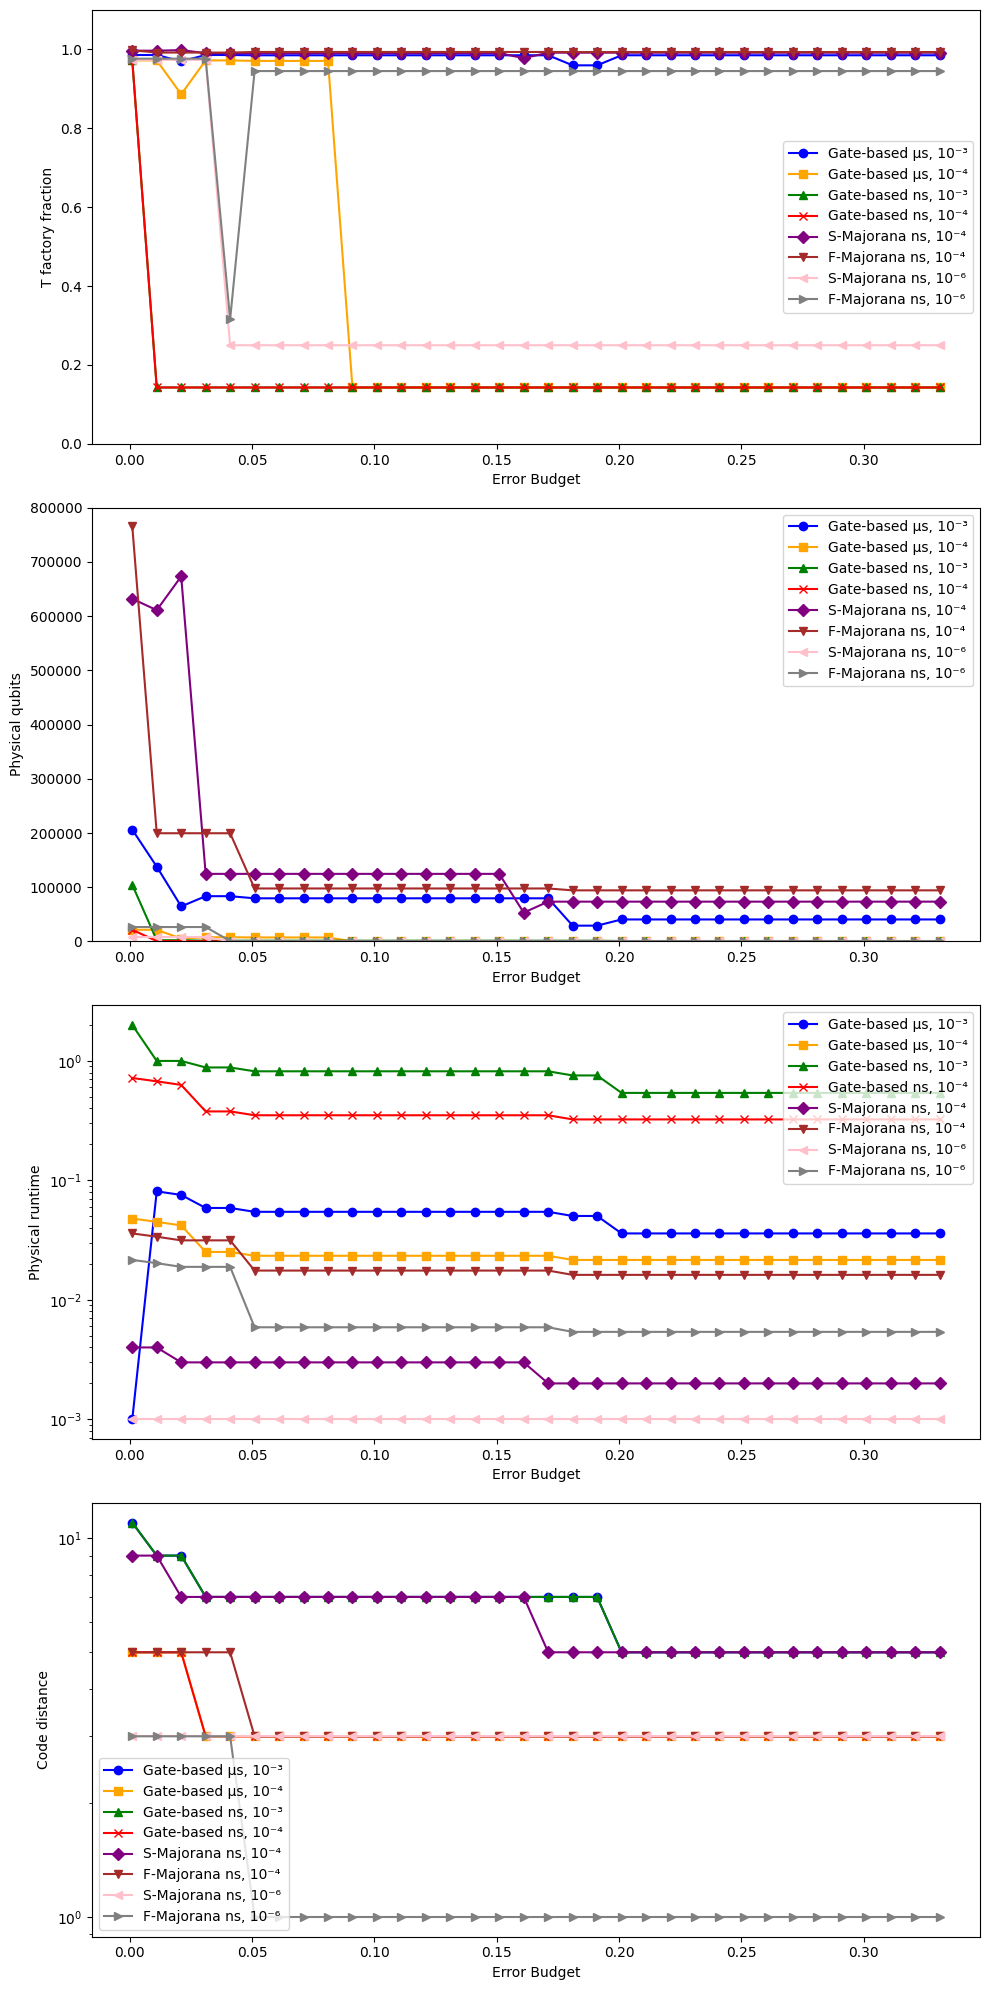

In [8]:
# Create a figure and axis objects
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))

# Define marker styles and colors for different circuit types
marker_styles = ['o', 's', '^', 'x', 'D', 'v', '<', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# Plot each metric on its own subplot
for i, metric in enumerate(['T factory fraction', 'Physical qubits', 'Physical runtime', 'Code distance']):
    ax = axes[i]
    if metric == 'T factory fraction':
        ax.set_ylim(0, 1.1)  # Set y-axis limit for T factory fraction
    elif metric == 'Physical qubits':
        ax.set_ylim(0, 800000)  # Set y-axis limit for Physical qubits
    else:
        ax.set_yscale('log')  # Set y-axis to logarithmic scale for other metrics
    for j, runName in enumerate(runNames):
        df_subset = df[df['Circuit Type'] == runName]
        ax.plot(df_subset['ErrorBudget'], df_subset[metric], marker=marker_styles[j], linestyle='-', color=colors[j], label=runName)
    ax.set_xlabel('Error Budget')
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout()
plt.show()


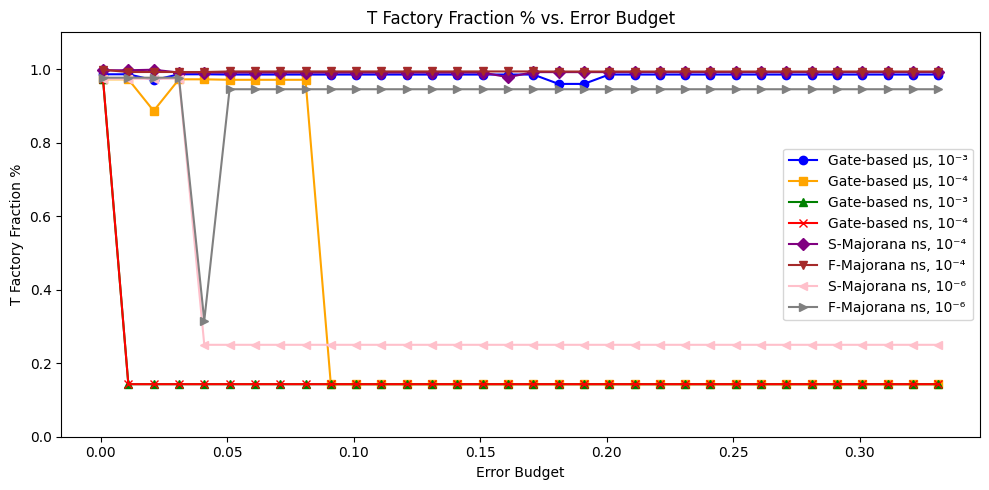

In [9]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 5))

# Define marker styles and colors for different circuit types
marker_styles = ['o', 's', '^', 'x', 'D', 'v', '<', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# Set y-axis limit for T factory fraction
ax.set_ylim(0, 1.1)

# Plot T factory fraction on its own subplot
for j, runName in enumerate(runNames):
    df_subset = df[df['Circuit Type'] == runName]
    ax.plot(df_subset['ErrorBudget'], df_subset['T factory fraction'], marker=marker_styles[j], linestyle='-', color=colors[j], label=runName)
ax.set_xlabel('Error Budget')
ax.set_ylabel('T Factory Fraction %')
ax.legend()


# Add title to the plot
ax.set_title('T Factory Fraction % vs. Error Budget')


plt.tight_layout()
plt.show()


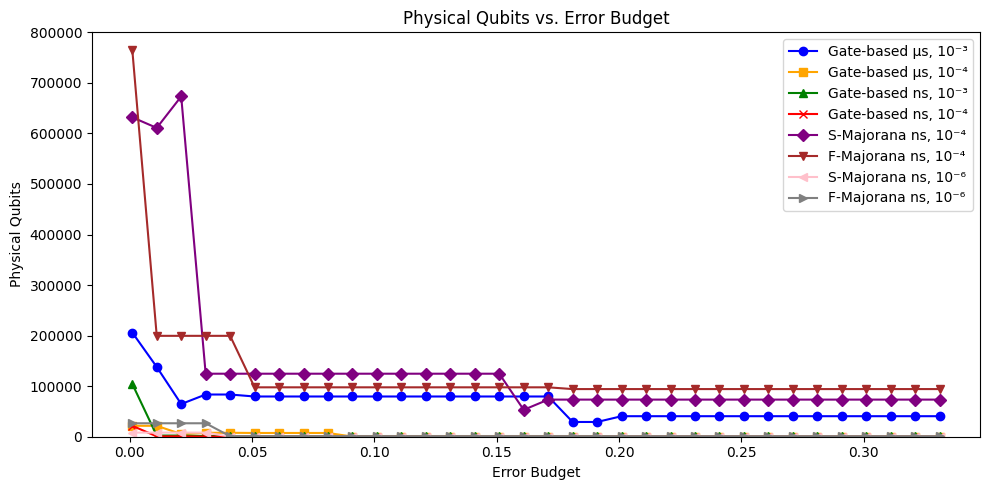

In [10]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 5))

# Define marker styles and colors for different circuit types
marker_styles = ['o', 's', '^', 'x', 'D', 'v', '<', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# Set y-axis limit for Physical qubits
ax.set_ylim(0, 800000)

# Plot Physical qubits on its own subplot
for j, runName in enumerate(runNames):
    df_subset = df[df['Circuit Type'] == runName]
    ax.plot(df_subset['ErrorBudget'], df_subset['Physical qubits'], marker=marker_styles[j], linestyle='-', color=colors[j], label=runName)
ax.set_xlabel('Error Budget')
ax.set_ylabel('Physical Qubits')
ax.legend()

# Add title to the plot
ax.set_title('Physical Qubits vs. Error Budget')



plt.tight_layout()
plt.show()


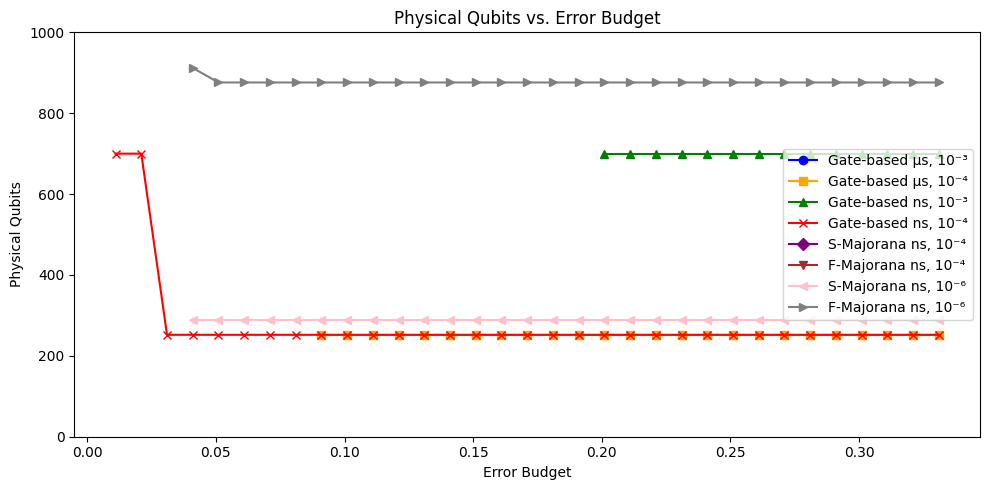

In [11]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 5))

# Define marker styles and colors for different circuit types
marker_styles = ['o', 's', '^', 'x', 'D', 'v', '<', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# Set y-axis limit for Physical qubits
ax.set_ylim(0, 1000)

# Plot Physical qubits on its own subplot
for j, runName in enumerate(runNames):
    df_subset = df[df['Circuit Type'] == runName]
    # Filter only the points less than 1000
    df_subset_filtered = df_subset[df_subset['Physical qubits'] < 1000]
    ax.plot(df_subset_filtered['ErrorBudget'], df_subset_filtered['Physical qubits'], marker=marker_styles[j], linestyle='-', color=colors[j], label=runName)
ax.set_xlabel('Error Budget')
ax.set_ylabel('Physical Qubits')
ax.legend(loc='center right')

# Add title to the plot
ax.set_title('Physical Qubits vs. Error Budget')




plt.tight_layout()
plt.show()


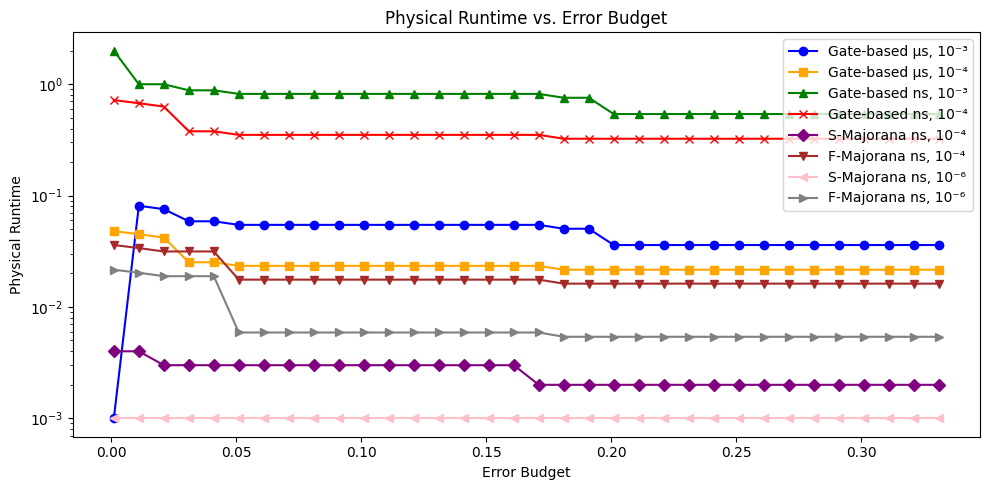

In [12]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 5))

# Define marker styles and colors for different circuit types
marker_styles = ['o', 's', '^', 'x', 'D', 'v', '<', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# Set y-axis to logarithmic scale for Physical runtime
ax.set_yscale('log')

# Plot Physical runtime on its own subplot
for j, runName in enumerate(runNames):
    df_subset = df[df['Circuit Type'] == runName]
    ax.plot(df_subset['ErrorBudget'], df_subset['Physical runtime'], marker=marker_styles[j], linestyle='-', color=colors[j], label=runName)
ax.set_xlabel('Error Budget')
ax.set_ylabel('Physical Runtime')
ax.legend()

# Add title to the plot
ax.set_title('Physical Runtime vs. Error Budget')


plt.tight_layout()
plt.show()


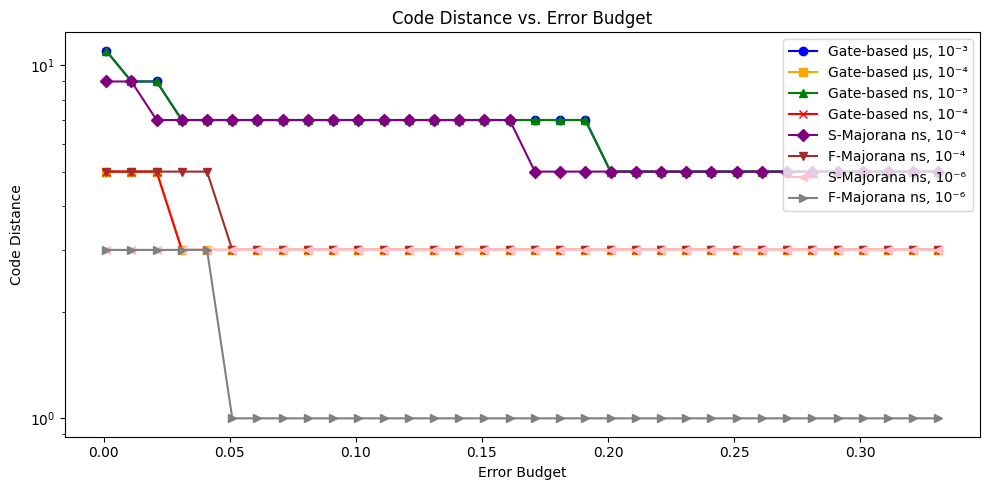

In [13]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 5))

# Define marker styles and colors for different circuit types
marker_styles = ['o', 's', '^', 'x', 'D', 'v', '<', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# Set y-axis to logarithmic scale for Code distance
ax.set_yscale('log')

# Plot Code distance on its own subplot
for j, runName in enumerate(runNames):
    df_subset = df[df['Circuit Type'] == runName]
    ax.plot(df_subset['ErrorBudget'], df_subset['Code distance'], marker=marker_styles[j], linestyle='-', color=colors[j], label=runName)
ax.set_xlabel('Error Budget')
ax.set_ylabel('Code Distance')
ax.legend(loc="upper right")

# Add title to the plot
ax.set_title('Code Distance vs. Error Budget')

plt.tight_layout()
plt.show()
